# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import string
import pandas as pd

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

## Дополнительно здесь убираем ненужные служебные символы

In [6]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
punctuation_wo_dot = "".join(list(set(string.punctuation) - set('.')))
print(punctuation_wo_dot)

!\$&}){-(~@;`#=^*[|_>:%+"'<,?]/


In [8]:
sentences = []
word_threshold = 32
# word_threshold = 100

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower().translate(str.maketrans(punctuation_wo_dot, ' '*len(punctuation_wo_dot))).replace('.', '') for x in sent_tokenize(sentence.replace('<br /><br />', ' '), language='english') if len(x.split(' ')) < word_threshold]
        )

# Получить отдельные предложения и поместить их в sentences

  0%|          | 0/25000 [00:00<?, ?it/s]

In [9]:
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [10]:
sentences[0:3]

['i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967',
 'the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life',
 'in between asking politicians and ordinary denizens of stockholm about their opinions on politics  she has sex with her drama teacher  classmates  and married men']

In [11]:
print(len(dataset['train']['text']))
print("Всего предложений:", len(sentences))

25000
Всего предложений: 272181


Посчитаем для каждого слова его встречаемость.

In [16]:
words = Counter()

count = 0
for sentence in tqdm(sentences):
    for word in sentence.split(' '):
        if word != '':
            words[word] += 1

# Расчет встречаемости слов

  0%|          | 0/272181 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [17]:
len(words)

67555

In [18]:
words_df_idxs = np.arange(len(words))

In [19]:
words_df = pd.DataFrame(data=list(words.items()),columns=['key','val'],index=words_df_idxs)

In [20]:
words_df_sorted = words_df.sort_values(by=['val'], ascending=False)

In [21]:
words_df_sorted_reindexed = words_df_sorted.reset_index(drop=True)

In [22]:
words_df_sorted_reindexed[0:40000]

,key,val
0,the,231358
1,a,112785
2,and,110392
3,of,97154
4,to,91870
...,...,...
39995,applicability,1
39996,liggin,1
39997,chiche,1
39998,grimly,1


In [23]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
# vocab_size = len(words_df_sorted_reindexed)

for i in words_df_sorted_reindexed[0:vocab_size]['key'].to_list():
    vocab.add(i)

# Наполнение словаря

In [24]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [25]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [26]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [27]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx].split(' ')]
        tokenized_sentence += [self.eos_id]
        # Допишите код здесь

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [28]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [29]:
np.random.seed(42)

train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [30]:
index = 10
print(train_dataset[index])
print(list(map(ind2word.get, train_dataset[index])))

[31299, 28943, 8788, 20691, 36374, 38997, 3473, 9531, 4355, 21530, 10286, 18852, 21923, 26406, 28133, 4449, 22642, 38326]
['<bos>', 'i', 've', 'just', 'watch', '2', 'films', 'of', 'pang', 'brothers', '<unk>', 'the', 'eye', 'and', 'one', 'take', 'only', '<eos>']


## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [31]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [32]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, epochs):
    losses = []
    perplexities = []

    for epoch in range(epochs):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, val_dataloader))

    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [33]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, embedding_len: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_len)
        self.rnn = nn.GRU(embedding_len, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection
        # А тут опишите forward pass модели

In [34]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab), embedding_len=128).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [35]:
model

LanguageModel(
  (embedding): Embedding(40004, 128)
  (rnn): GRU(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=40004, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [36]:
%%time

history = train_model(model, criterion=criterion, optimizer=optimizer,
                      train_dataloader=train_dataloader, val_dataloader=eval_dataloader,
                      epochs=5)

# Обучите модель здесь

Training epoch 0::   0%|          | 0/1702 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1702 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1702 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1702 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1702 [00:00<?, ?it/s]

CPU times: user 20min 47s, sys: 5.86 s, total: 20min 53s
Wall time: 21min 11s


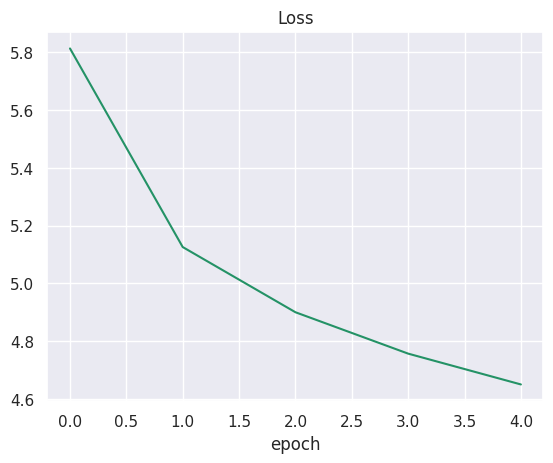

In [37]:
plt.plot(np.arange(len(history[0])), history[0])
plt.title('Loss')
plt.xlabel("epoch")
plt.show()

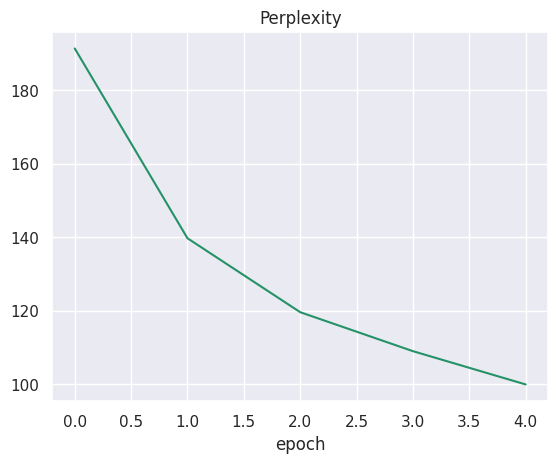

In [38]:
plt.plot(np.arange(len(history[1])), history[1])
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [39]:
perplexity_test = evaluate(model, criterion, test_dataloader)
print(f'perplexity_test = {perplexity_test}')

perplexity_test = 100.30718530927386


In [40]:
print(f'perplexity_test = {np.around(perplexity_test,0)}')

perplexity_test = 100.0


In [41]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 32) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split(' ')]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    return input_ids

    # words = ''.join([ind2word[idx.item()] for idx in input_ids])

    # return words

In [42]:
out_ids = generate_sequence(model, starting_seq="i want to")

In [48]:
print(out_ids)
print([ind2word[out_ids[i].item()] for i in range(0,len(out_ids))])

tensor([31299, 28943, 28732, 28782, 25350, 22344, 18659, 39997, 28943, 21630,
        26256, 14511, 39997, 28943, 21630, 26256, 19755, 39997, 25601, 29315,
        22344, 18659, 39997, 29315, 13637, 22344, 28231, 18659, 38326])
['<bos>', 'i', 'want', 'to', 'see', 'a', 'movie', 'that', 'i', 'can', 't', 'say', 'that', 'i', 'can', 't', 'believe', 'that', 'it', 'is', 'a', 'movie', 'that', 'is', 'not', 'a', 'good', 'movie', '<eos>']


In [49]:
len(out_ids)

29

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
# Проведите второй эксперимент

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.